In [118]:
# Importando as bibliotecas necessárias.

import os
import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings
import tensorflow_datasets.public_api as tfds

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization

import matplotlib.pyplot as plt

# Define o backend do Keras para o TensorFlow.
os.environ["KERAS_BACKEND"] = "tensorflow"


### Objetivo do Código: Carregar e Preparar Dados de Tradução a partir de um Arquivo TSV

Este código lê um arquivo TSV contendo dados textuais, extrai pares de frases em francês e português, e armazena esses pares em uma lista para uso em tarefas de processamento de linguagem natural ou treinamento de modelos de tradução. Para o texto em português, são adicionados marcadores especiais de início (`[start]`) e fim (`[end]`) para auxiliar na identificação dos limites da sequência.

#### Passo a Passo do Código:

1. **Inicialização da Lista de Pares**:
   - Cria a lista `text_pairs` que armazenará os pares de textos extraídos do arquivo.

2. **Abertura e Leitura do Arquivo**:
   - O arquivo `"data.tsv"` é aberto em modo leitura (`"r"`) com codificação `UTF-8` para garantir a correta interpretação dos caracteres.
   - O arquivo é processado linha a linha.

3. **Processamento de Cada Linha**:
   - **Limpeza e Divisão**:
     - Cada linha é "limpa" com `strip()` para remover espaços em branco extras e, em seguida, dividida em campos usando o separador de tabulação (`\t`) através de `split("\t")`.
   - **Validação dos Campos**:
     - O código verifica se a linha possui pelo menos 4 campos (índices 0 a 3). Se a condição não for atendida, a linha é ignorada (com `continue`).

4. **Extração dos Textos**:
   - **Texto em Francês**:
     - Extraído do segundo campo da linha (`fields[1]`).
   - **Texto em Português**:
     - Extraído do quarto campo (`fields[3]`).
     - Os tokens especiais `[start]` e `[end]` são adicionados, respectivamente, no início e no final do texto, para indicar os limites da sequência.

5. **Armazenamento dos Pares**:
   - Cada par formado pelo texto em francês e o texto modificado em português é adicionado à lista `text_pairs`.

6. **Verificação dos Dados Carregados**:
   - O primeiro par da lista é impresso para garantir que a extração e a formatação foram realizadas corretamente.

Este procedimento é fundamental para preparar os dados de entrada que serão utilizados posteriormente no treinamento de modelos de tradução automática ou outras tarefas relacionadas a NLP.


In [119]:
# Inicializa uma lista para armazenar os pares de textos
text_pairs = []

# Abre o arquivo "data.tsv" no modo de leitura com codificação UTF-8
with open("data.tsv", "r", encoding="utf-8") as f:
    # Itera por cada linha do arquivo
    for line in f:
        # Remove espaços extras e divide a linha utilizando a tabulação como separador
        fields = line.strip().split("\t")
        # Garante que a linha possui ao menos 4 campos (índices 0 a 3)
        if len(fields) < 4:
            continue
        french = fields[1]  # Obtém a segunda coluna (texto em francês)
        portuguese = "[start] " + fields[3] + " [end]"  # Obtém a quarta coluna (texto em português) e adiciona os marcadores de início e fim
        text_pairs.append((french, portuguese))

# Imprime o primeiro par de textos para verificação
print(text_pairs[0])


('Je ne supporte pas ce type.', '[start] Eu não suporto esse tipo. [end]')


In [120]:
# Itera 5 vezes para imprimir 5 pares de textos escolhidos aleatoriamente
for _ in range(5):
    # Seleciona um par de textos aleatório da lista 'text_pairs' e o imprime
    print(random.choice(text_pairs))


('La couleur blonde est ma couleur de cheveux naturelle.', '[start] O loiro é a minha cor natural de cabelo. [end]')
('Si nécessaire, je viendrai à neuf heures demain.', '[start] Se necessário, eu virei amanhã às nove horas. [end]')
('Je dois te demander pardon.', '[start] Preciso te pedir perdão. [end]')
('Tous sont là.', '[start] Todos estão aqui. [end]')
('Les feux tricolores sont utilisés pour réguler le trafic.', '[start] Os semáforos são usados para regular o tráfego. [end]')


### Objetivo do Código: Dividir os Pares de Textos em Conjuntos de Treinamento, Validação e Teste

Este trecho de código realiza a divisão dos pares de textos em três conjuntos distintos: treinamento, validação e teste. Essa separação é fundamental para treinar o modelo com um conjunto de dados, ajustar os hiperparâmetros com outro e avaliar o desempenho final utilizando dados nunca vistos durante o treinamento.

#### Passo a Passo do Código:

1. **Embaralhamento dos Pares de Textos**:
   - `random.shuffle(text_pairs)`
     - Embaralha aleatoriamente a lista `text_pairs` para garantir que os dados sejam distribuídos de forma aleatória, evitando qualquer viés que possa estar presente na ordem original.

2. **Cálculo do Número de Amostras para Validação**:
   - `num_val_samples = int(0.15 * len(text_pairs))`
     - Calcula 15% do total de pares de textos para compor o conjunto de validação. Essa proporção ajuda a monitorar a performance do modelo em dados não utilizados no treinamento.

3. **Determinação do Número de Amostras para Treinamento**:
   - `num_train_samples = len(text_pairs) - 2 * num_val_samples`
     - Define o número de pares para treinamento reservando duas vezes a quantidade de amostras de validação: uma por conjunto de validação e outra por conjunto de teste. Essa estratégia mantém uma divisão balanceada dos dados.

4. **Divisão dos Dados**:
   - **Conjunto de Treinamento**:
     - `train_pairs = text_pairs[:num_train_samples]`
       - Seleciona os primeiros `num_train_samples` pares para formar o conjunto de treinamento.
   - **Conjunto de Validação**:
     - `val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]`
       - Os pares imediatamente após o conjunto de treinamento são alocados para a validação.
   - **Conjunto de Teste**:
     - `test_pairs = text_pairs[num_train_samples + num_val_samples :]`
       - Os pares restantes são destinados ao conjunto de teste.

5. **Exibição da Divisão dos Dados**:
   - São exibidos os números totais de pares e a quantidade de pares atribuídos a cada conjunto:
     - `print(f"{len(text_pairs)} total pairs")`
     - `print(f"{len(train_pairs)} training pairs")`
     - `print(f"{len(val_pairs)} validation pairs")`
     - `print(f"{len(test_pairs)} test pairs")`

Esta abordagem assegura uma divisão estruturada dos dados, permitindo um treinamento robusto e uma avaliação imparcial do modelo de tradução.


In [121]:
# Embaralha aleatoriamente os pares de textos
random.shuffle(text_pairs)

# Calcula o número de amostras para validação como 15% do total de pares
num_val_samples = int(0.15 * len(text_pairs))

# Define o número de amostras para treinamento, reservando 2 blocos de validação (um para validação e outro para teste)
num_train_samples = len(text_pairs) - 2 * num_val_samples

# Separa os pares para treinamento
train_pairs = text_pairs[:num_train_samples]

# Separa os pares para validação (logo após os pares de treinamento)
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]

# Separa os pares para teste (os pares restantes após treinamento e validação)
test_pairs = text_pairs[num_train_samples + num_val_samples :]

# Exibe a quantidade total de pares, bem como a divisão em treinamento, validação e teste
print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")


33030 total pairs
23122 training pairs
4954 validation pairs
4954 test pairs


### Objetivo do Código: Configurar o Pré-processamento e a Vetorização dos Textos

Este trecho de código define os parâmetros e as funções necessárias para a padronização e vetorização dos textos utilizados no treinamento do modelo de tradução. Ele especifica quais caracteres de pontuação devem ser removidos (exceto os colchetes, para preservar tokens especiais), configura os hiperparâmetros para o processamento dos textos e cria camadas de vetorização personalizadas para os idiomas francês e português.

#### Passo a Passo do Código:

1. **Definição dos Caracteres de Pontuação a Serem Removidos**:
   - `strip_chars = string.punctuation + "«" + "»"`  
     Combina os caracteres de pontuação padrão com os caracteres "«" e "»".
   - `strip_chars = strip_chars.replace("[", "")`  
     Remove o caractere "[" da lista, para não afetar tokens especiais como `[start]`.
   - `strip_chars = strip_chars.replace("]", "")`  
     Remove o caractere "]" da lista, garantindo que tokens especiais sejam preservados.

2. **Configuração dos Parâmetros para o Processamento**:
   - `vocab_size = 25000`  
     Define o tamanho máximo do vocabulário.
   - `sequence_length = 20`  
     Define o comprimento máximo das sequências de saída.
   - `batch_size = 64`  
     Define o tamanho dos lotes (batch size) para o treinamento.
   - `latentSpaceDimension = 32`  
     Define a dimensão do espaço latente, que pode ser utilizada em modelos de codificação (por exemplo, na camada LSTM).

3. **Implementação da Função de Padronização Customizada**:
   - **Função `custom_standardization(input_string)`**:
     - Converte o texto para minúsculas usando `tf_strings.lower(input_string)`.
     - Remove os caracteres indesejados definidos em `strip_chars` utilizando uma expressão regular com `tf_strings.regex_replace` e `re.escape(strip_chars)`.
     - Essa padronização garante que o texto seja uniforme, facilitando o aprendizado pelo modelo.

4. **Criação das Camadas de Vetorização**:
   - **Para o Texto em Francês**:
     - `french_vectorization = TextVectorization(...)`:
       - `max_tokens=vocab_size`: Limita o número de tokens no vocabulário.
       - `output_mode="int"`: Converte os textos em sequências de inteiros (índices dos tokens).
       - `output_sequence_length=sequence_length`: Define o comprimento fixo das sequências.
   - **Para o Texto em Português**:
     - `portuguese_vectorization = TextVectorization(...)`:
       - Configurado de forma similar ao francês, porém com `output_sequence_length=sequence_length + 1` para acomodar um token extra (por exemplo, tokens especiais de início ou fim).
       - Aplica a padronização customizada definida em `custom_standardization` para limpar e uniformizar os textos.

5. **Extração dos Textos dos Pares de Treinamento**:
   - `train_french_texts = [pair[0] for pair in train_pairs]`  
     Cria uma lista contendo os textos em francês dos pares de treinamento.
   - `train_portuguese_texts = [pair[1] for pair in train_pairs]`  
     Cria uma lista contendo os textos em português dos pares de treinamento.

6. **Adaptação das Camadas de Vetorização**:
   - `french_vectorization.adapt(train_french_texts)`  
     Ajusta a camada de vetorização para o francês aos dados de treinamento, permitindo que ela aprenda o vocabulário e os padrões dos textos.
   - `portuguese_vectorization.adapt(train_portuguese_texts)`  
     Ajusta a camada de vetorização para o português aos dados de treinamento, garantindo que os textos sejam convertidos corretamente em sequências numéricas.

Esta etapa de pré-processamento é crucial para converter os dados textuais brutos em um formato adequado para o treinamento de modelos de tradução, garantindo consistência e preservação dos tokens especiais durante a vetorização.


In [122]:
# Define os caracteres de pontuação que serão removidos durante a padronização,
# adicionando os caracteres "«" e "»".
strip_chars = string.punctuation + "«" + "»"

# Remove os colchetes dos caracteres a serem removidos, mantendo-os no texto
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

# Define os parâmetros para o processamento dos textos
vocab_size = 25000       # Tamanho máximo do vocabulário
sequence_length = 20     # Comprimento máximo das sequências de saída
batch_size = 64          # Tamanho do lote (batch)
latentSpaceDimension = 32# Dimensão do espaço latente (latent space dimension).

def custom_standardization(input_string):
    """
    Função de padronização customizada para os textos.

    Converte o texto para minúsculas e remove os caracteres definidos em 'strip_chars'.
    """
    # Converte o texto para letras minúsculas
    lowercase = tf_strings.lower(input_string)
    # Remove os caracteres indesejados utilizando uma expressão regular
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Cria a camada de vetorização para os textos em francês
french_vectorization = TextVectorization(
    max_tokens=vocab_size,           # Número máximo de tokens
    output_mode="int",               # Saída como inteiros (índices dos tokens)
    output_sequence_length=sequence_length,  # Comprimento fixo das sequências
)

# Cria a camada de vetorização para os textos em português,
# utilizando a função de padronização customizada
portuguese_vectorization = TextVectorization(
    max_tokens=vocab_size,                # Número máximo de tokens
    output_mode="int",                    # Saída como inteiros (índices dos tokens)
    output_sequence_length=sequence_length + 1,  # Comprimento fixo das sequências (+1 para token especial)
    standardize=custom_standardization,   # Função customizada para padronização dos textos
)

# Extrai os textos em francês e português dos pares de treinamento
train_french_texts = [pair[0] for pair in train_pairs]      # Lista de textos em francês
train_portuguese_texts = [pair[1] for pair in train_pairs]    # Lista de textos em português

# Adapta as camadas de vetorização aos textos de treinamento
french_vectorization.adapt(train_french_texts)
portuguese_vectorization.adapt(train_portuguese_texts)


### Objetivo do Código: Formatar e Criar Conjuntos de Dados para Treinamento e Validação

Este trecho de código define duas funções que transformam os pares de textos em um formato adequado para o treinamento do modelo de tradução. Ele converte os textos em sequências numéricas utilizando as camadas de vetorização previamente definidas e organiza os dados em um dataset do TensorFlow, otimizando o pipeline com operações de batching, caching, embaralhamento e prefetch.

#### Passo a Passo do Código:

1. **Função `format_dataset`**:
   - **Entrada**:
     - Recebe duas entradas: `french` e `portuguese`, que são textos em francês e português, respectivamente.
   - **Vetorização**:
     - Aplica a camada de vetorização `french_vectorization` aos textos em francês, convertendo-os em sequências numéricas.
     - Aplica a camada de vetorização `portuguese_vectorization` aos textos em português.
   - **Preparação dos Dados para o Modelo Encoder-Decoder**:
     - Cria um dicionário contendo:
       - `"encoder_inputs"`: as sequências numéricas dos textos em francês.
       - `"decoder_inputs"`: as sequências dos textos em português, mas excluindo o último token (`portuguese[:, :-1]`), preparando os dados para o *teacher forcing*.
     - Retorna os rótulos para o decodificador (`decoder_target`), que são as sequências em português deslocadas uma posição para a direita (`portuguese[:, 1:]`), isto é, sem o primeiro token.
     
2. **Função `make_dataset`**:
   - **Entrada**:
     - Recebe `pairs`, uma lista de tuplas contendo pares de textos (francês, português).
   - **Separação dos Textos**:
     - Utiliza `zip(*pairs)` para descompactar os pares em duas listas: `french_texts` e `portuguese_texts`.
   - **Criação do Dataset**:
     - Converte as listas de textos em um dataset do TensorFlow usando `tf_data.Dataset.from_tensor_slices`.
   - **Batching**:
     - Agrupa os dados em lotes (batches) utilizando o parâmetro `batch_size` previamente definido.
   - **Mapeamento com a Função de Formatação**:
     - Aplica a função `format_dataset` a cada batch do dataset para transformar os textos em suas respectivas sequências numéricas e organizar as entradas para o modelo.
   - **Otimização do Pipeline**:
     - Utiliza `cache()` para armazenar os dados em cache e acelerar o acesso em épocas subsequentes.
     - Embaralha os dados com `shuffle(2048)` para aumentar a aleatoriedade.
     - Pré-carrega os batches com `prefetch(16)` para otimizar o desempenho durante o treinamento.
   - **Retorno**:
     - Retorna o dataset otimizado para uso no treinamento ou validação.

3. **Criação dos Conjuntos de Dados de Treinamento e Validação**:
   - `train_ds = make_dataset(train_pairs)`:
     - Cria o dataset de treinamento a partir dos pares de textos definidos para treinamento.
   - `val_ds = make_dataset(val_pairs)`:
     - Cria o dataset de validação a partir dos pares de textos reservados para validação.

Este pipeline assegura que os dados textuais estejam devidamente processados e organizados em um formato compatível com o modelo de tradução, otimizando a leitura e o pré-processamento durante o treinamento.


In [123]:
def format_dataset(french, portuguese):
    # Aplica a vetorização nos textos em francês
    french = french_vectorization(french)
    # Aplica a vetorização nos textos em português
    portuguese = portuguese_vectorization(portuguese)
    # Retorna um dicionário com as entradas para o codificador e decodificador,
    # além dos rótulos para o treinamento do decodificador.
    return (
        {
            "encoder_inputs": french,          # Entrada para o codificador
            "decoder_inputs": portuguese[:, :-1],  # Entrada para o decodificador (exclui o último token)
        },
        portuguese[:, 1:],  # Rótulos para o decodificador (exclui o primeiro token)
    )


def make_dataset(pairs):
    # Separa os textos em francês e português dos pares fornecidos
    french_texts, portuguese_texts = zip(*pairs)
    french_texts = list(french_texts)
    portuguese_texts = list(portuguese_texts)

    # Cria um dataset do TensorFlow a partir dos textos
    dataset = tf_data.Dataset.from_tensor_slices((french_texts, portuguese_texts))
    # Agrupa os exemplos em lotes (batch)
    dataset = dataset.batch(batch_size)
    # Aplica a formatação dos dados utilizando a função format_dataset
    dataset = dataset.map(format_dataset)
    # Armazena o dataset em cache, embaralha e pré-carrega os lotes para otimizar o desempenho
    return dataset.cache().shuffle(2048).prefetch(16)


# Cria os datasets de treinamento e validação a partir dos pares correspondentes
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)


In [124]:
# Itera sobre o primeiro lote do dataset de treinamento
for inputs, targets in train_ds.take(1):
    # Imprime a forma do tensor que contém as entradas para o codificador
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')

    # Imprime a forma do tensor que contém as entradas para o decodificador
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')

    # Imprime a forma do tensor que contém os alvos (saídas) para o treinamento do decodificador
    print(f"targets.shape: {targets.shape}")


inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


In [125]:
# Imprime os 5 primeiros textos em francês dos dados de treinamento
print(train_french_texts[:5])

# Imprime os 5 primeiros textos em português dos dados de treinamento
print(train_portuguese_texts[:5])


["C'est un organisme unicellulaire.", 'Plus nous avons, plus nous voulons.', 'Quelle route emprunter ?', "Tout ce que je veux, c'est ton chat.", 'Je ne les déboîte pas.']
['[start] Esse é um organismo unicelular. [end]', '[start] Quanto mais nós temos, mais nós queremos ter. [end]', '[start] Que caminho tomar? [end]', '[start] Tudo o que eu quero é o seu gato. [end]', '[start] Eu não os desencaixo. [end]']


### Objetivo do Código: Implementar a Camada de Atenção Bahdanau

Esta classe define a camada de atenção Bahdanau, uma técnica fundamental em modelos seq2seq que permite ao decoder focar nas partes mais relevantes das saídas do encoder. A camada calcula um vetor de contexto ponderado e os pesos de atenção correspondentes, contribuindo para melhorar a qualidade da tradução ou geração de texto.

#### Passo a Passo do Código:

1. **Inicialização da Classe (`__init__`)**:
   - **Parâmetros**:
     - `units`: Número de unidades para as camadas densas internas, definindo a dimensão do espaço de atenção.
     - `verbose`: Nível de detalhamento para debug (padrão é 0).
   - **Camadas Internas**:
     - `self.W1`: Camada densa que transforma a **query** (por exemplo, o estado atual do decoder).
     - `self.W2`: Camada densa que transforma os **valores** (por exemplo, as saídas do encoder).
     - `self.V`: Camada densa que gera os scores de atenção, reduzindo a soma das transformações a um único valor por posição.

2. **Método `call`**:
   - **Entradas**:
     - `query` (Tensor): Vetor de consulta com shape `(batch_size, hidden_size)`.
     - `values` (Tensor): Valores do encoder com shape `(batch_size, time_steps, hidden_size)`.
   - **Processamento**:
     - **Expansão da Query**:
       - A query é expandida com `tf.expand_dims(query, 1)` para criar uma dimensão temporal, resultando em shape `(batch_size, 1, hidden_size)`. Isso permite a soma com os valores, que possuem uma dimensão temporal.
     - **Cálculo dos Scores de Atenção**:
       - Aplica-se `self.W1` à query expandida e `self.W2` aos valores.
       - A soma dessas transformações é passada pela função `tf.nn.tanh` para introduzir não-linearidade.
       - A camada `self.V` é aplicada ao resultado, produzindo os scores com shape `(batch_size, time_steps, 1)`.
     - **Normalização com Softmax**:
       - Os scores são normalizados com `tf.nn.softmax` ao longo do eixo temporal (axis=1), gerando os **pesos de atenção** que indicam a relevância de cada valor.
     - **Cálculo do Vetor de Contexto**:
       - Os pesos de atenção são multiplicados pelos valores para ponderar a contribuição de cada posição.
       - A soma ao longo do eixo temporal (`tf.reduce_sum`) resulta no **vetor de contexto** com shape `(batch_size, hidden_size)`.
   - **Saídas**:
     - `context_vector`: Vetor de contexto que agrega a informação dos valores com base nos pesos de atenção.
     - `attention_weights`: Pesos de atenção, fornecendo uma medida da importância de cada posição da sequência de entrada.

Este mecanismo de atenção permite que o decoder acesse dinamicamente informações relevantes do encoder, melhorando a capacidade do modelo de lidar com sequências longas e complexas, e contribuindo para um desempenho superior em tarefas de tradução e outras aplicações em NLP.


In [126]:
# Supondo que a classe de atenção Bahdanau já esteja definida corretamente:
class BahdanauAttention(layers.Layer):
    def __init__(self, units, verbose=0):
        """
        Inicializa a camada de atenção Bahdanau.

        Args:
            units (int): Número de unidades para as camadas densas internas.
            verbose (int, opcional): Nível de detalhamento para debug. Padrão é 0.
        """
        super(BahdanauAttention, self).__init__()
        # Camadas densas para transformar a query e os valores
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        # Camada densa para gerar os scores de atenção
        self.V = layers.Dense(1)
        self.verbose = verbose

    def call(self, query, values):
        """
        Executa a atenção Bahdanau.

        Args:
            query (Tensor): Vetor de consulta com shape (batch_size, hidden_size).
            values (Tensor): Valores com shape (batch_size, time_steps, hidden_size).

        Returns:
            context_vector (Tensor): Vetor de contexto com shape (batch_size, hidden_size).
            attention_weights (Tensor): Pesos de atenção com shape (batch_size, time_steps, 1).
        """
        # Adiciona uma dimensão temporal à query para permitir a soma com os valores.
        # Novo shape: (batch_size, 1, hidden_size)
        query_with_time_axis = tf.expand_dims(query, 1)

        # Calcula os scores de atenção combinando a query e os valores.
        # A função tanh é aplicada após as transformações lineares.
        # Resultado: (batch_size, time_steps, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # Normaliza os scores usando softmax para obter os pesos de atenção.
        # Shape: (batch_size, time_steps, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # Multiplica os pesos de atenção pelos valores para obter o vetor de contexto.
        # Shape intermediário: (batch_size, time_steps, hidden_size)
        context_vector = attention_weights * values

        # Reduz a soma ao longo do eixo temporal para combinar as informações.
        # Shape final: (batch_size, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


### Objetivo do Código: Aplicar a Atenção de Forma Distribuída no Tempo aos Outputs do Decodificador

Esta classe, `TimeDistributedAttention`, é uma camada customizada que permite aplicar uma camada de atenção (por exemplo, Bahdanau) a cada timestep dos outputs do decodificador de um modelo seq2seq. Isso possibilita que, para cada instante temporal do decodificador, seja calculado um vetor de contexto que reflete a relevância dos estados do encoder naquele instante, contribuindo para uma melhor performance no processo de decodificação.

#### Passo a Passo do Código:

1. **Inicialização da Camada (`__init__`)**:
   - **Parâmetro**:
     - `attention_layer`: Uma instância de uma camada de atenção (por exemplo, uma implementação de BahdanauAttention) que será aplicada a cada timestep.
   - **Processamento**:
     - A classe herda de `layers.Layer` e inicializa a camada pai utilizando `super()`.
     - Armazena a camada de atenção fornecida na variável `self.attention_layer`.

2. **Método `call`**:
   - **Entrada**:
     - `inputs`: Uma lista contendo dois tensores:
       - `decoder_outputs`: Saídas do decodificador com shape `(batch_size, dec_timesteps, latentSpaceDimension)`.
       - `encoder_outputs`: Saídas do encoder com shape `(batch_size, enc_timesteps, latentSpaceDimension)`.
   - **Processamento**:
     - **Desempacotamento das Entradas**:
       - Os tensores de `decoder_outputs` e `encoder_outputs` são extraídos da lista `inputs`.
     - **Transposição dos Outputs do Decodificador**:
       - Transpõe `decoder_outputs` de modo que o eixo temporal (timestep) fique como primeiro eixo, transformando o shape para `(dec_timesteps, batch_size, latentSpaceDimension)`. Essa transposição facilita a aplicação da atenção para cada timestep individualmente.
     - **Definição da Função Interna `apply_attention`**:
       - Essa função é aplicada a cada vetor de timestep do decodificador.
       - **Entrada**:
         - `decoder_timestep`: Vetor referente a um único timestep, com shape `(batch_size, latentSpaceDimension)`.
       - **Processamento**:
         - Utiliza o vetor do timestep como *query* para a camada de atenção, passando-o juntamente com `encoder_outputs` como *values*.
         - Calcula o vetor de contexto (e os pesos de atenção, que não são utilizados posteriormente) para esse timestep.
       - **Saída**:
         - Retorna o vetor de contexto para o timestep, com shape `(batch_size, latentSpaceDimension)`.
     - **Aplicação da Atenção em Cada Timestep**:
       - Utiliza `tf.map_fn` para aplicar a função `apply_attention` a cada elemento do tensor transposto `decoder_outputs_transposed`.
       - O resultado é um tensor com shape `(dec_timesteps, batch_size, latentSpaceDimension)`.
     - **Retorno ao Formato Original**:
       - Transpõe o tensor resultante de volta para o formato original, resultando em um tensor `context_sequence` com shape `(batch_size, dec_timesteps, latentSpaceDimension)`.
   - **Saída do Método**:
     - Retorna `context_sequence`, que é a sequência de vetores de contexto calculados para cada timestep do decodificador.

#### Considerações Adicionais:
- **Uso de `tf.map_fn`**:
  - Essa função permite iterar sobre o eixo temporal, aplicando a função de atenção para cada timestep de forma independente.
- **Integração com Modelos Seq2Seq**:
  - A camada `TimeDistributedAttention` pode ser integrada ao pipeline do modelo, combinando os outputs do decodificador com os estados do encoder para fornecer informações contextuais em cada passo de decodificação.

Este mecanismo de atenção distribuída no tempo melhora a capacidade do modelo de se concentrar dinamicamente nas partes relevantes da entrada durante o processo de decodificação, contribuindo para resultados mais precisos em tarefas como tradução automática e geração de linguagem natural.


In [127]:

# Camada customizada para aplicar a atenção para cada timestep do decodificador
class TimeDistributedAttention(layers.Layer):
    def __init__(self, attention_layer, **kwargs):
        """
        Inicializa a camada de atenção distribuída no tempo.

        Args:
            attention_layer (layers.Layer): Instância da camada de atenção a ser aplicada.
            **kwargs: Argumentos adicionais para a camada pai.
        """
        super(TimeDistributedAttention, self).__init__(**kwargs)
        self.attention_layer = attention_layer

    def call(self, inputs):
        """
        Aplica a atenção a cada timestep dos outputs do decodificador.

        Args:
            inputs (list): Lista contendo [decoder_outputs, encoder_outputs] onde:
                - decoder_outputs: (batch_size, dec_timesteps, latentSpaceDimension)
                - encoder_outputs: (batch_size, enc_timesteps, latentSpaceDimension)

        Returns:
            context_sequence (Tensor): Sequência de vetores de contexto para cada timestep do decodificador,
                                       com shape (batch_size, dec_timesteps, latentSpaceDimension).
        """
        # Desempacota as entradas: outputs do decodificador e do codificador
        decoder_outputs, encoder_outputs = inputs

        # Transpõe os outputs do decodificador para iterar sobre o eixo temporal.
        # Novo shape: (dec_timesteps, batch_size, latentSpaceDimension)
        decoder_outputs_transposed = tf.transpose(decoder_outputs, perm=[1, 0, 2])

        # Função que aplica a atenção para um único timestep do decodificador.
        def apply_attention(decoder_timestep):
            """
            Aplica a atenção para um timestep específico.

            Args:
                decoder_timestep (Tensor): Vetor do timestep do decodificador com shape (batch_size, latentSpaceDimension).

            Returns:
                context (Tensor): Vetor de contexto calculado para o timestep com shape (batch_size, latentSpaceDimension).
            """
            # Utiliza o vetor do timestep como query para calcular a atenção sobre os encoder_outputs.
            context, _ = self.attention_layer(decoder_timestep, encoder_outputs)
            return context

        # Aplica a função de atenção para cada timestep usando tf.map_fn.
        # O resultado possui shape: (dec_timesteps, batch_size, latentSpaceDimension)
        context_sequence_transposed = tf.map_fn(
            apply_attention,
            decoder_outputs_transposed,
            fn_output_signature=tf.float32
        )

        # Transpõe de volta para o formato original: (batch_size, dec_timesteps, latentSpaceDimension)
        context_sequence = tf.transpose(context_sequence_transposed, perm=[1, 0, 2])
        return context_sequence


### Objetivo do Código: Implementar uma Camada de Embedding Posicional

Esta classe, `PositionalEmbedding`, define uma camada customizada que combina os embeddings dos tokens com embeddings de posição. Essa técnica é crucial em modelos que processam sequências, pois permite que o modelo incorpore informações sobre a ordem dos tokens, além das suas representações semânticas.

#### Passo a Passo do Código:

1. **Definição da Classe e Inicialização (`__init__`)**:
   - **Parâmetros de Inicialização**:
     - `sequence_length`: Comprimento máximo da sequência, determinando o número de posições possíveis.
     - `vocab_size`: Tamanho do vocabulário, ou seja, o número total de tokens únicos que serão representados.
     - `embed_dim`: Dimensão dos embeddings, que define o tamanho dos vetores que representarão cada token e cada posição.
     - `**kwargs`: Permite passar argumentos adicionais para a classe base (`layers.Layer`).
   - **Criação das Camadas de Embedding**:
     - `self.token_embeddings`: Uma camada `Embedding` que mapeia os índices dos tokens para vetores de dimensão `embed_dim`.
     - `self.position_embeddings`: Uma camada `Embedding` que mapeia os índices de posição (de 0 até `sequence_length - 1`) para vetores de dimensão `embed_dim`.
   - **Armazenamento de Parâmetros**:
     - Os parâmetros `sequence_length`, `vocab_size` e `embed_dim` são armazenados como atributos da classe para referência posterior, inclusive na serialização da camada.

2. **Método `call`**:
   - **Entrada**:
     - `inputs`: Tensor contendo índices dos tokens com shape `(batch_size, sequence_length)`.
   - **Processamento**:
     - **Embedding dos Tokens**:
       - Aplica `self.token_embeddings` ao tensor `inputs` para obter os embeddings dos tokens com shape `(batch_size, sequence_length, embed_dim)`.
     - **Criação e Processamento dos Embeddings de Posição**:
       - Cria um tensor constante `positions` que contém uma sequência de índices de 0 até `sequence_length - 1` utilizando `tf.range()`.
       - Passa os índices de posição pela camada `self.position_embeddings` para obter os embeddings correspondentes, com shape `(sequence_length, embed_dim)`.
       - Expande a dimensão dos embeddings de posição para `(1, sequence_length, embed_dim)` com `tf.expand_dims()`, permitindo a soma com os embeddings dos tokens para cada amostra no batch.
     - **Soma dos Embeddings**:
       - Soma os embeddings dos tokens com os embeddings das posições para incorporar a informação de posição em cada token.
   - **Saída**:
     - Retorna um tensor com shape `(batch_size, sequence_length, embed_dim)`, onde cada token foi enriquecido com a informação da sua posição na sequência.

3. **Método `get_config`**:
   - **Objetivo**:
     - Permitir a serialização da camada, facilitando a salvaguarda e a reconstrução do modelo.
   - **Processamento**:
     - Obtém a configuração da camada base com `super().get_config()`.
     - Atualiza o dicionário de configuração com os parâmetros `sequence_length`, `vocab_size` e `embed_dim`.
   - **Saída**:
     - Retorna um dicionário com a configuração completa da camada.

Esta camada é frequentemente utilizada em arquiteturas modernas de NLP (como Transformers) para garantir que o modelo não apenas entenda os tokens isoladamente, mas também a ordem e a posição relativa dos tokens dentro da sequência.


In [128]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

class PositionalEmbedding(layers.Layer):
    """
    Camada de embedding posicional que soma os embeddings dos tokens e das posições.
    """

    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        """
        Inicializa a camada de embedding posicional.

        Args:
            sequence_length (int): Comprimento máximo da sequência.
            vocab_size (int): Tamanho do vocabulário.
            embed_dim (int): Dimensão dos embeddings.
            **kwargs: Argumentos adicionais para a classe base.
        """
        super().__init__(**kwargs)
        # Embedding para os tokens com dimensão de entrada igual ao tamanho do vocabulário
        # e dimensão de saída igual a embed_dim
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        # Embedding para as posições com dimensão de entrada igual ao comprimento da sequência
        # e dimensão de saída igual a embed_dim
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        """
        Soma os embeddings dos tokens e das posições.

        Args:
            inputs (Tensor): Tensores contendo índices dos tokens com shape
                             (batch_size, sequence_length).

        Returns:
            Tensor: Soma dos embeddings dos tokens e das posições com shape
                    (batch_size, sequence_length, embed_dim).
        """
        # Obtém os embeddings dos tokens: shape (batch_size, sequence_length, embed_dim)
        embedded_tokens = self.token_embeddings(inputs)

        # Cria um tensor constante com as posições: shape (sequence_length,)
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)

        # Obtém os embeddings das posições: shape (sequence_length, embed_dim)
        embedded_positions = self.position_embeddings(positions)

        # Expande a dimensão para que os embeddings das posições possam ser somados
        # aos embeddings dos tokens em todas as amostras do batch.
        # Novo shape: (1, sequence_length, embed_dim)
        embedded_positions = tf.expand_dims(embedded_positions, axis=0)

        # Retorna a soma dos embeddings dos tokens com os embeddings das posições
        return embedded_tokens + embedded_positions

    def get_config(self):
        """
        Retorna a configuração da camada para possibilitar a serialização.

        Returns:
            dict: Dicionário de configuração da camada.
        """
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


### Objetivo do Código: Implementar uma Célula LSTM com Mecanismo de Atenção Integrada

Esta classe, `AttentionLSTMCell`, implementa uma célula LSTM customizada que integra um mecanismo de atenção em cada passo de tempo. Essa abordagem permite que a célula utilize informações contextuais do encoder para influenciar a geração da saída no decoder, combinando a robustez da LSTM com a capacidade de focar em partes relevantes da entrada.

#### Passo a Passo do Código:

1. **Inicialização da Célula (`__init__`)**:
   - **Parâmetros**:
     - `units` (int): Número de unidades da LSTM, determinando a dimensionalidade dos estados internos.
     - `attention_layer` (layers.Layer): Instância da camada de atenção (por exemplo, BahdanauAttention) que será aplicada para calcular o vetor de contexto.
     - `**kwargs`: Argumentos adicionais para a camada base.
   - **Processamento**:
     - Armazena o número de unidades em `self.units`.
     - A camada de atenção é armazenada em `self.attention_layer`.
     - Cria uma instância padrão de `layers.LSTMCell` com o número de unidades especificado, armazenada em `self.lstm_cell`.

2. **Definição das Propriedades de Estado e Saída**:
   - **`state_size`**:
     - Retorna uma lista que define os tamanhos dos estados internos da célula:
       - **hidden**: Vetor oculto com dimensão `units`.
       - **cell**: Vetor da célula com dimensão `units`.
       - **prev_attention**: Vetor de atenção do timestep anterior com dimensão `units` (usado para input feeding).
       - **encoder_outputs**: Estados do encoder com shape `(None, units)`, onde `None` indica que o número de timesteps pode variar.
   - **`output_size`**:
     - Define o tamanho da saída da célula como a soma das dimensões do novo estado oculto e do vetor de contexto, resultando em `units + units`.

3. **Método `call`**:
   - **Entradas**:
     - `inputs` (Tensor): Embedding do token atual, com shape `(batch_size, embed_dim)`.
     - `states` (lista): Contém os estados anteriores no seguinte formato:
       - `hidden`: Estado oculto da LSTM.
       - `cell`: Estado da célula da LSTM.
       - `prev_attention`: Vetor de atenção do timestep anterior (para input feeding).
       - `encoder_outputs`: Saídas do encoder, que permanecem constantes durante a decodificação.
   - **Processamento**:
     - **Input Feeding**:
       - Concatena o embedding do token atual (`inputs`) com o vetor de atenção do timestep anterior (`prev_attention`) usando `tf.concat`. Isso fornece à LSTM um contexto adicional sobre a atenção calculada anteriormente.
     - **Passagem pela LSTMCell**:
       - O vetor combinado (`input_combined`) é processado pela célula LSTM padrão (`self.lstm_cell`), gerando um novo estado oculto (`new_hidden`) e um novo estado da célula (`new_cell`).
     - **Cálculo da Atenção**:
       - Utiliza a camada de atenção (`self.attention_layer`) para calcular o vetor de contexto. O `new_hidden` é usado como *query* e `encoder_outputs` como *values*. O mecanismo retorna o vetor de contexto (`context_vector`) e os pesos de atenção (que podem ser utilizados para interpretação, mas não são propagados adiante neste contexto).
     - **Formação da Saída**:
       - A saída da célula é definida como a concatenação do novo estado oculto (`new_hidden`) com o vetor de contexto (`context_vector`), formando `new_output` com dimensão `units + units`.
     - **Atualização dos Estados**:
       - Os estados são atualizados para o próximo timestep com a lista:
         - `new_hidden`: O novo estado oculto.
         - `new_cell`: O novo estado da célula.
         - `context_vector`: O vetor de contexto atual, que servirá como `prev_attention` no próximo timestep.
         - `encoder_outputs`: Mantido inalterado, pois os outputs do encoder não variam durante a decodificação.
   - **Saída**:
     - Retorna uma tupla contendo:
       - `new_output`: A saída combinada da célula para o timestep atual.
       - `new_state`: A lista atualizada dos estados para uso no próximo timestep.

Este design permite que o modelo integre de maneira eficaz o mecanismo de atenção dentro do fluxo recursivo da LSTM, melhorando a capacidade do decoder de acessar informações relevantes do encoder em cada passo do processo de geração de sequência.


In [129]:
class AttentionLSTMCell(layers.Layer):
    """
    Célula LSTM com mecanismo de atenção integrada.
    Esta célula utiliza um mecanismo de atenção (attention_layer)
    para calcular um vetor de contexto a cada timestep, que é concatenado
    com o novo estado oculto da LSTM para formar a saída.
    """

    def __init__(self, units, attention_layer, **kwargs):
        """
        Inicializa a célula LSTM com atenção.

        Args:
            units (int): Número de unidades da LSTM.
            attention_layer (layers.Layer): Camada de atenção a ser utilizada.
            **kwargs: Argumentos adicionais.
        """
        super(AttentionLSTMCell, self).__init__(**kwargs)
        self.units = units  # Número de unidades para a LSTM
        self.attention_layer = attention_layer  # Mecanismo de atenção a ser aplicado
        self.lstm_cell = layers.LSTMCell(units)  # Instância da célula LSTM padrão

    @property
    def state_size(self):
        """
        Define o tamanho dos estados internos da célula.

        Retorna uma lista contendo:
          - hidden: vetor oculto com dimensão (units)
          - cell: vetor de célula com dimensão (units)
          - prev_attention: vetor de atenção do timestep anterior com dimensão (units)
          - encoder_outputs: estados do encoder com shape (None, units)
            (None indica que o número de timesteps do encoder pode variar)
        """
        return [self.units, self.units, self.units, tf.TensorShape([None, self.units])]

    @property
    def output_size(self):
        """
        Define o tamanho da saída da célula.

        A saída é a concatenação do novo estado oculto e do vetor de contexto,
        portanto, sua dimensão é a soma das dimensões dos dois vetores.
        """
        return self.units + self.units

    def call(self, inputs, states):
        """
        Executa um passo de tempo da célula LSTM com atenção.

        Args:
            inputs (Tensor): Embedding do token atual com shape (batch_size, embed_dim).
            states (list): Lista contendo os estados anteriores:
                [hidden, cell, prev_attention, encoder_outputs]

        Retorna:
            new_output (Tensor): Saída da célula com shape (batch_size, output_size),
                                 que é a concatenação do novo estado oculto e do vetor de contexto.
            new_state (list): Lista atualizada dos estados, mantendo os valores para:
                              [new_hidden, new_cell, context_vector, encoder_outputs].
        """
        # Desempacota os estados: hidden, cell, atenção anterior e outputs do encoder
        hidden, cell, prev_attention, encoder_outputs = states

        # Concatena o embedding do token atual com o vetor de atenção do timestep anterior (input feeding)
        input_combined = tf.concat([inputs, prev_attention], axis=-1)

        # Processa o input combinado pela LSTMCell para obter o novo estado oculto e o novo estado da célula
        output, [new_hidden, new_cell] = self.lstm_cell(input_combined, [hidden, cell])

        # Calcula a atenção utilizando o novo estado oculto como query e os outputs do encoder como values
        context_vector, attention_weights = self.attention_layer(new_hidden, encoder_outputs)

        # Define a saída da célula como a concatenação do novo estado oculto com o vetor de contexto
        new_output = tf.concat([new_hidden, context_vector], axis=-1)

        # Atualiza os estados:
        # - new_hidden: novo estado oculto da LSTM
        # - new_cell: novo estado da célula da LSTM
        # - context_vector: vetor de contexto obtido pela atenção (será usado no próximo timestep)
        # - encoder_outputs: permanece constante ao longo da decodificação
        new_state = [new_hidden, new_cell, context_vector, encoder_outputs]

        return new_output, new_state


### Objetivo do Código: Construir o Encoder e o Decoder com Mecanismo de Atenção Integrada

Este trecho de código implementa a arquitetura de um modelo seq2seq que utiliza um encoder baseado em LSTM e um decoder customizado com um mecanismo de atenção. O objetivo é mapear uma sequência de entrada (por exemplo, em uma tarefa de tradução) para uma sequência de saída, permitindo que o decoder acesse dinamicamente as informações relevantes dos outputs do encoder por meio de atenção.

---

#### 1. Adaptação dos Outputs do Encoder para o Espaço Latente

- **Camada Densa Adaptadora**:
  - `encoder_adapter = layers.Dense(latentSpaceDimension, activation='relu', name='encoder_adapter')`
  - Essa camada transforma os outputs do encoder para o espaço latente definido por `latentSpaceDimension`, utilizando a ativação ReLU para introduzir não-linearidade.

---

#### 2. Construção do Encoder

- **Entrada do Encoder**:
  - `encoder_inputs = Input(shape=(None,), dtype="int64", name="encoder_inputs")`
  - Recebe sequências de índices (tokens) de comprimento variável.

- **Embedding Posicional**:
  - `encoder_embed = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)`
  - Aplica a camada de embedding posicional para incorporar tanto as representações dos tokens quanto as informações de posição.

- **LSTM do Encoder**:
  - `encoder_lstm = layers.LSTM(latentSpaceDimension, return_sequences=True, return_state=True, name='encoder_lstm')`
  - Processa a sequência de embeddings e retorna:
    - `encoder_outputs`: Sequência de saídas em cada timestep.
    - `state_h` e `state_c`: Estados finais (oculto e célula), que serão utilizados para inicializar o decoder.
  - Armazena os estados finais em `encoder_states = [state_h, state_c]`.

- **Adaptação dos Outputs do Encoder**:
  - `adapted_encoder_outputs = encoder_adapter(encoder_outputs)`
  - Os outputs do encoder são transformados para o espaço latente, fornecendo informações contextuais a serem usadas pela camada de atenção no decoder.

---

#### 3. Construção do Decoder

- **Entrada do Decoder**:
  - `decoder_inputs = Input(shape=(None,), dtype="int64", name="decoder_inputs")`
  - Recebe sequências de índices (tokens) de comprimento variável que representam a entrada do decoder.

- **Embedding dos Tokens do Decoder**:
  - `decoder_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(decoder_inputs)`
  - Converte os tokens do decoder em vetores de embedding.

- **Configuração do Decoder com Atenção**:
  - **Custom Attention LSTM Cell**:
    - `attention_cell = AttentionLSTMCell(latentSpaceDimension, attention_layer)`
    - Utiliza uma célula LSTM customizada que integra um mecanismo de atenção (por meio de `attention_layer`) para calcular, a cada timestep, um vetor de contexto que auxilia o decoder.
  - **Camada RNN com a Célula Customizada**:
    - `decoder_rnn = layers.RNN(attention_cell, return_sequences=True, return_state=True)`
    - Cria uma camada RNN que processará os embeddings do decoder utilizando a célula customizada de LSTM com atenção.

- **Inicialização do Vetor de Atenção**:
  - **Função Auxiliar**:
    - ```python
      def get_initial_attention(x):
          batch_size = tf.shape(x)[0]
          return tf.zeros((batch_size, latentSpaceDimension), dtype=tf.float32)
      ```
    - Essa função gera um vetor de zeros para cada exemplo no batch, servindo como o vetor de atenção inicial.
  - **Cálculo do Vetor de Atenção Inicial**:
    - `initial_attention = layers.Lambda(get_initial_attention)(state_h)`
    - Utiliza o estado oculto do encoder (`state_h`) para determinar o batch size e inicializa o vetor de atenção com zeros.

- **Definição do Estado Inicial do Decoder**:
  - `initial_state = encoder_states + [initial_attention, adapted_encoder_outputs]`
  - O estado inicial do decoder é composto por:
    - `state_h` e `state_c`: Estados finais do encoder.
    - `initial_attention`: Vetor de atenção inicial (zeros).
    - `adapted_encoder_outputs`: Outputs do encoder adaptados para o espaço latente, que servirão como valores para o mecanismo de atenção durante a decodificação.

- **Execução da RNN do Decoder**:
  - `decoder_rnn_outputs = decoder_rnn(decoder_embeddings, initial_state=initial_state)`
  - Processa os embeddings do decoder utilizando o estado inicial definido.
  - A camada RNN retorna uma tupla onde o primeiro elemento é a sequência resultante dos outputs processados.

- **Extração dos Outputs do Decoder**:
  - `decoder_outputs = decoder_rnn_outputs[0]`
  - Essa variável contém a sequência de saídas do decoder, que poderá ser posteriormente transformada (por exemplo, via uma camada densa) para predição dos tokens de saída.

---

#### Resumo do Fluxo do Modelo

1. **Encoder**:
   - Recebe uma sequência de tokens, aplica embeddings posicionais e processa a sequência com uma LSTM.
   - Os outputs do encoder são adaptados para um espaço latente e os estados finais são capturados.

2. **Decoder**:
   - Recebe uma sequência de tokens de entrada (por exemplo, tokens de início para geração de sequência).
   - Converte os tokens em embeddings e os processa por uma camada RNN que utiliza uma célula LSTM com atenção.
   - O mecanismo de atenção utiliza os estados do encoder para calcular, a cada timestep, um vetor de contexto que é combinado com o novo estado oculto para formar a saída do decoder.

Este design integra de forma robusta o mecanismo de atenção ao fluxo recursivo do decoder, permitindo que o modelo foque em partes relevantes da sequência de entrada a cada passo de decodificação, o que é crucial para tarefas como tradução automática, sumarização e outras aplicações em NLP.


In [130]:
# Camada densa para adaptar os outputs do encoder para o espaço latente
encoder_adapter = layers.Dense(latentSpaceDimension, activation='relu', name='encoder_adapter')

# --- Parâmetros e camadas de embedding (assumindo que já estejam definidos) ---
# sequence_length: comprimento máximo da sequência
# vocab_size: tamanho do vocabulário
# embed_dim: dimensão dos embeddings dos tokens
# latentSpaceDimension: dimensão do espaço latente

# --- Encoder ---
# Entrada para o encoder: sequência de índices (tokens) com tamanho variável
encoder_inputs = Input(shape=(None,), dtype="int64", name="encoder_inputs")
# Aplica o embedding posicional nos tokens do encoder
encoder_embed = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
# Camada LSTM do encoder que retorna tanto as sequências quanto os estados finais
encoder_lstm = layers.LSTM(latentSpaceDimension,
                           return_sequences=True,
                           return_state=True,
                           name='encoder_lstm')
# Processa a sequência de embeddings e obtém os outputs e os estados finais (hidden e cell)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embed)
# Armazena os estados finais do encoder para uso posterior no decoder
encoder_states = [state_h, state_c]

# Adapta os outputs do encoder para o espaço latente usando a camada densa definida anteriormente
adapted_encoder_outputs = encoder_adapter(encoder_outputs)

# --- Decoder ---
# Entrada para o decoder: sequência de índices (tokens) com tamanho variável
decoder_inputs = Input(shape=(None,), dtype="int64", name="decoder_inputs")
# Aplica a camada de embedding para os tokens do decoder
decoder_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(decoder_inputs)

# Cria o cell customizado de LSTM com atenção (input feeding) utilizando a AttentionLSTMCell
attention_cell = AttentionLSTMCell(latentSpaceDimension, attention_layer)
# Cria uma camada RNN que utiliza a célula customizada, retornando sequências e estados
decoder_rnn = layers.RNN(attention_cell, return_sequences=True, return_state=True)

# Função auxiliar para inicializar o vetor de atenção com zeros para cada exemplo do batch
def get_initial_attention(x):
    batch_size = tf.shape(x)[0]
    return tf.zeros((batch_size, latentSpaceDimension), dtype=tf.float32)

# Inicializa o vetor de atenção com zeros, utilizando o estado hidden do encoder como base para definir o batch size
initial_attention = layers.Lambda(get_initial_attention)(state_h)

# Define o estado inicial do decoder como a combinação dos estados do encoder e o vetor de atenção inicial:
# [hidden, cell, prev_attention, adapted_encoder_outputs]
initial_state = encoder_states + [initial_attention, adapted_encoder_outputs]

# Executa a RNN do decoder, processando os embeddings do decoder com o estado inicial definido
decoder_rnn_outputs = decoder_rnn(decoder_embeddings, initial_state=initial_state)
# A saída do decoder é a sequência resultante (primeiro elemento do retorno da RNN)
decoder_outputs = decoder_rnn_outputs[0]


/home/bruno/Documents/unb/tema/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'attention_lstm_cell_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


### Objetivo do Código: Construir e Compilar o Modelo Seq2Seq com Mecanismo de Atenção e Input Feeding

Este trecho final de código monta o modelo seq2seq, integrando o decoder com o mecanismo de atenção e input feeding. A camada densa final converte os outputs do decoder em predições sobre o vocabulário, e o modelo é compilado com o otimizador Adam e a função de perda de entropia cruzada esparsa.

#### Passo a Passo do Código:

1. **Camada Densa Final para Geração de Predições**:
   - **Definição da Camada**:
     - ```python
       decoder_dense = layers.Dense(vocab_size, activation='softmax', name='decoder_dense')
       ```
     - Esta camada transforma os outputs do decoder em uma distribuição de probabilidade sobre o vocabulário, utilizando a ativação `softmax` para garantir que as probabilidades somem 1.

   - **Aplicação da Camada aos Outputs do Decoder**:
     - ```python
       final_outputs = decoder_dense(decoder_outputs)
       ```
     - Os outputs processados pelo decoder são passados pela camada densa, gerando as predições finais.

2. **Definição do Modelo Final**:
   - **Construção do Modelo**:
     - ```python
       model = Model([encoder_inputs, decoder_inputs], final_outputs, name='seq2seq_input_feeding')
       ```
     - O modelo é definido para receber duas entradas:
       - `encoder_inputs`: Sequência de tokens para o encoder.
       - `decoder_inputs`: Sequência de tokens para o decoder.
     - A saída do modelo são as predições finais (`final_outputs`), que representam a distribuição de probabilidade sobre o vocabulário para cada posição na sequência de saída.

3. **Compilação do Modelo**:
   - **Configuração da Compilação**:
     - ```python
       model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
       ```
     - O modelo é compilado com:
       - **Otimizador**: `adam`, que adapta os parâmetros durante o treinamento.
       - **Função de Perda**: `sparse_categorical_crossentropy`, apropriada para classificação multi-classe onde os rótulos são inteiros.
       - **Métrica**: `accuracy`, para monitorar a performance do modelo durante o treinamento e a validação.

4. **Exibição do Resumo da Arquitetura do Modelo**:
   - **Resumo do Modelo**:
     - ```python
       model.summary()
       ```
     - Imprime um resumo detalhado da arquitetura do modelo, mostrando as camadas, a forma dos tensores e o número de parâmetros treináveis.

---

Este modelo seq2seq, que integra mecanismos de atenção com input feeding, está preparado para tarefas de tradução, sumarização ou outras aplicações de processamento de linguagem natural, onde é essencial que o decoder tenha acesso contextual dinâmico às informações processadas pelo encoder.


In [131]:
# Camada densa final para gerar as predições a partir dos outputs do decoder.
decoder_dense = layers.Dense(vocab_size, activation='softmax', name='decoder_dense')
final_outputs = decoder_dense(decoder_outputs)

# --- Modelo Final ---
# Define o modelo sequencial que recebe as entradas do encoder e do decoder,
# e produz as predições finais.
model = Model([encoder_inputs, decoder_inputs], final_outputs, name='seq2seq_input_feeding')

# Compila o modelo utilizando o otimizador Adam, a função de perda
# de entropia cruzada esparsa e a métrica de acurácia.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Exibe um resumo da arquitetura do modelo.
model.summary()


Model: "seq2seq_input_feeding"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 20, 128)   │  3,202,560 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 20, 32),  │     20,608 │ positional_embed… │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_30        │ (None, None, 128) │  3,200,000 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 32)        │          0 │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_adapter     │ (None, 20, 32)    │      1,056 │ encoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn_3 (RNN)         │ [(None, None,     │      2,145 │ embedding_30[0][… │
│                     │ 64), (None, 32),  │            │ encoder_lstm[0][… │
│                     │ (None, 32),       │            │ encoder_lstm[0][… │
│                     │ (None, 32)]       │            │ lambda_3[0][0],   │
│                     │                   │            │ encoder_adapter[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, None,      │  1,625,000 │ rnn_3[0][0]       │
│ (Dense)             │ 25000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,051,369 (30.71 MB)

 Trainable params: 8,051,369 (30.71 MB)

 Non-trainable params: 0 (0.00 B)

### Objetivo do Código: Preparar Dados de Treinamento e Teste, Treinar e Avaliar o Modelo Seq2Seq com Atenção

Este trecho de código realiza as seguintes operações:
- Converte os textos brutos (tanto de treinamento quanto de teste) em arrays numéricos utilizando as camadas de vetorização.
- Prepara as sequências de entrada e as sequências alvo para o decoder, aplicando o conceito de *teacher forcing* (deslocamento das sequências).
- Treina o modelo seq2seq com atenção utilizando os dados preparados.
- Avalia o desempenho do modelo no conjunto de teste e imprime as métricas de perda e acurácia.

---

#### 1. Preparação dos Dados de Treinamento

- **Encoder Inputs:**
  - Os textos em francês de treinamento são convertidos para arrays de inteiros:
    ```python
    encoder_input_data = french_vectorization(np.array(train_french_texts)).numpy()
    ```
    - Cada elemento do array representa uma sequência de índices correspondentes aos tokens.

- **Decoder Inputs e Targets:**
  - Os textos em português de treinamento são convertidos para arrays tokenizados:
    ```python
    portuguese_tokenized = portuguese_vectorization(np.array(train_portuguese_texts)).numpy()
    ```
  - **Decoder Input Data:**
    - São utilizados todos os tokens, exceto o último, para formar a sequência de entrada do decoder:
      ```python
      decoder_input_data = portuguese_tokenized[:, :-1]
      ```
  - **Decoder Target Data:**
    - São utilizados todos os tokens, exceto o primeiro, de forma que o modelo aprenda a prever o próximo token:
      ```python
      decoder_target_data = portuguese_tokenized[:, 1:]
      ```

---

#### 2. Preparação dos Dados de Teste

- **Extração dos Textos de Teste:**
  - Os textos em francês e português são extraídos dos pares de teste:
    ```python
    test_french_texts = [pair[0] for pair in test_pairs]
    test_portuguese_texts = [pair[1] for pair in test_pairs]
    ```
- **Conversão para Arrays Numéricos:**
  - Os textos em francês e português são convertidos para arrays de inteiros:
    ```python
    encoder_input_test = french_vectorization(np.array(test_french_texts)).numpy()
    portuguese_tokenized_test = portuguese_vectorization(np.array(test_portuguese_texts)).numpy()
    ```
- **Preparação das Sequências para o Decoder:**
  - As entradas e os alvos do decoder são preparados da mesma forma que nos dados de treinamento:
    ```python
    decoder_input_test = portuguese_tokenized_test[:, :-1]
    decoder_target_test = portuguese_tokenized_test[:, 1:]
    ```

---

#### 3. Treinamento do Modelo

- O modelo é treinado utilizando os arrays preparados:
  ```python
  history = model.fit(
      x=[encoder_input_data, decoder_input_data],
      y=decoder_target_data,
      batch_size=64,
      epochs=30,
      validation_data=([encoder_input_test, decoder_input_test], decoder_target_test)
  )
  ```
  - **Entradas:**
    - `[encoder_input_data, decoder_input_data]`: Dados de entrada para o encoder e o decoder.
  - **Saída Alvo:**
    - `decoder_target_data`: Sequência que o modelo deve aprender a prever.
  - **Configuração:**
    - Batch size de 64 e 30 épocas.
    - Uso de dados de validação para monitorar o desempenho durante o treinamento.
  - O histórico de treinamento é armazenado na variável `history`.

---

#### 4. Avaliação do Modelo

- Após o treinamento, o modelo é avaliado utilizando os dados de teste:
  ```python
  test_loss, test_accuracy = model.evaluate(
      x=[encoder_input_test, decoder_input_test],
      y=decoder_target_test
  )
  ```
  - O método `evaluate` retorna a perda e a acurácia no conjunto de teste.

- **Exibição dos Resultados:**
  - Os valores de perda e acurácia são impressos:
    ```python
    print("Test loss:", test_loss)
    print("Test accuracy:", test_accuracy)
    ```

---

### Resumo

- **Conversão e Preparação dos Dados:**  
  Os textos brutos são convertidos para arrays numéricos utilizando camadas de vetorização, e as sequências de entrada e alvo são ajustadas para o treinamento com *teacher forcing*.

- **Treinamento:**  
  O modelo é treinado com os dados preparados e validado em um conjunto separado de teste.

- **Avaliação:**  
  O desempenho do modelo é avaliado e os resultados (perda e acurácia) são exibidos.

Este fluxo garante que o modelo esteja pronto para lidar com a tarefa de tradução ou geração de sequências, utilizando a robustez do mecanismo de atenção integrado.

In [132]:
# =============================================================================
# Preparação dos arrays para treinamento e teste a partir dos textos brutos
# =============================================================================

# --- Dados de Treinamento ---
# Converte os textos de treinamento para arrays utilizando as camadas de vetorização.
# O resultado é um array de inteiros para o encoder.
encoder_input_data = french_vectorization(np.array(train_french_texts)).numpy()

# Converte os textos de treinamento do português para arrays tokenizados.
# O resultado é um array onde cada linha representa uma sequência tokenizada.
portuguese_tokenized = portuguese_vectorization(np.array(train_portuguese_texts)).numpy()

# Para o decoder, definimos:
# - decoder_input_data: sequência de entrada do decoder (todos os tokens, exceto o último),
#   pois o modelo recebe essa sequência para prever o próximo token.
# - decoder_target_data: sequência alvo (todos os tokens, exceto o primeiro), que é o que o
#   modelo deve prever.
decoder_input_data = portuguese_tokenized[:, :-1]
decoder_target_data = portuguese_tokenized[:, 1:]

# --- Dados de Teste ---
# Extrai os textos de teste dos pares e converte utilizando as camadas de vetorização.

# Obtém os textos em francês e português dos pares de teste
test_french_texts = [pair[0] for pair in test_pairs]
test_portuguese_texts = [pair[1] for pair in test_pairs]

# Converte os textos de teste para arrays de inteiros
encoder_input_test = french_vectorization(np.array(test_french_texts)).numpy()
portuguese_tokenized_test = portuguese_vectorization(np.array(test_portuguese_texts)).numpy()

# Prepara as sequências para o decoder no teste, seguindo a mesma lógica aplicada aos dados de treinamento.
decoder_input_test = portuguese_tokenized_test[:, :-1]
decoder_target_test = portuguese_tokenized_test[:, 1:]

# =============================================================================
# Treinamento e Avaliação do Modelo com a Nova Arquitetura (com atenção)
# =============================================================================

# Treina o modelo utilizando os arrays preparados para o encoder e decoder.
history = model.fit(
    x=[encoder_input_data, decoder_input_data],
    y=decoder_target_data,
    batch_size=64,
    epochs=30,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test)
)

# Avalia o modelo no conjunto de teste.
test_loss, test_accuracy = model.evaluate(
    x=[encoder_input_test, decoder_input_test],
    y=decoder_target_test
)

# Exibe os resultados da avaliação no teste.
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)


Epoch 1/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 94s 236ms/step - accuracy: 0.6434 - loss: 4.6661 - val_accuracy: 0.7010 - val_loss: 2.1632
Epoch 2/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 89s 245ms/step - accuracy: 0.7041 - loss: 2.0725 - val_accuracy: 0.7101 - val_loss: 2.0720
Epoch 3/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 89s 247ms/step - accuracy: 0.7179 - loss: 1.9415 - val_accuracy: 0.7180 - val_loss: 2.0037
Epoch 4/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 90s 248ms/step - accuracy: 0.7237 - loss: 1.8574 - val_accuracy: 0.7238 - val_loss: 1.9522
Epoch 5/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 88s 243ms/step - accuracy: 0.7334 - loss: 1.7577 - val_accuracy: 0.7309 - val_loss: 1.9025
Epoch 6/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 86s 238ms/step - accuracy: 0.7390 - loss: 1.6830 - val_accuracy: 0.7347 - val_loss: 1.8634
Epoch 7/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 82s 227ms/step - accuracy: 0.7466 - loss: 1.6029 - val_accuracy: 0.7399 - val_loss: 1.8399
Epoch 8/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 82s 228ms/step - accuracy: 0.7535 - loss: 1

### Objetivo do Código: Visualizar o Histórico de Acurácia e Perda Durante o Treinamento

Este trecho de código utiliza a biblioteca Matplotlib para plotar gráficos que resumem o desempenho do modelo ao longo das épocas, tanto para o conjunto de treinamento quanto para o de validação. As visualizações ajudam a identificar o comportamento do modelo durante o treinamento, permitindo monitorar a convergência e detectar possíveis problemas como overfitting.

#### Passo a Passo:

1. **Plotagem da Acurácia**:
   - **Dados Utilizados**:
     - `history.history['accuracy']`: Lista com os valores de acurácia obtidos durante o treinamento em cada época.
     - `history.history['val_accuracy']`: Lista com os valores de acurácia no conjunto de validação em cada época.
   - **Configuração do Gráfico**:
     - `plt.plot(history.history['accuracy'])`: Plota a acurácia do treinamento.
     - `plt.plot(history.history['val_accuracy'])`: Plota a acurácia da validação.
     - `plt.title(model.name + ' accuracy')`: Define o título do gráfico, combinando o nome do modelo com a palavra "accuracy".
     - `plt.ylabel('accuracy')`: Rótulo para o eixo y, representando a acurácia.
     - `plt.xlabel('epoch')`: Rótulo para o eixo x, representando as épocas.
     - `plt.legend(['train', 'val'], loc='upper left')`: Adiciona uma legenda para distinguir as curvas de treinamento e validação, posicionada no canto superior esquerdo.
   - **Exibição**:
     - `plt.show()`: Exibe o gráfico de acurácia.

2. **Plotagem da Perda (Loss)**:
   - **Dados Utilizados**:
     - `history.history['loss']`: Lista com os valores de perda durante o treinamento.
     - `history.history['val_loss']`: Lista com os valores de perda durante a validação.
   - **Configuração do Gráfico**:
     - `plt.plot(history.history['loss'])`: Plota a perda do treinamento.
     - `plt.plot(history.history['val_loss'])`: Plota a perda da validação.
     - `plt.title(model.name + ' loss')`: Define o título do gráfico, combinando o nome do modelo com a palavra "loss".
     - `plt.ylabel('loss')`: Rótulo para o eixo y, representando a perda.
     - `plt.xlabel('epoch')`: Rótulo para o eixo x, representando as épocas.
     - `plt.legend(['train', 'val'], loc='upper left')`: Adiciona uma legenda para identificar as curvas de treinamento e validação.
   - **Exibição**:
     - `plt.show()`: Exibe o gráfico de perda.

---

Esses gráficos permitem monitorar visualmente o desempenho do modelo, facilitando a identificação de melhorias necessárias no treinamento ou ajustes na arquitetura.


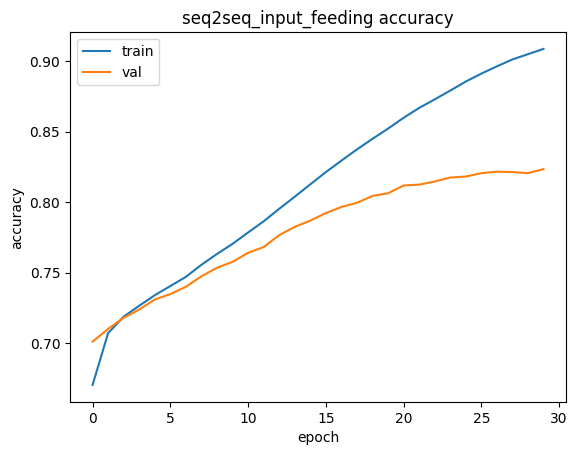

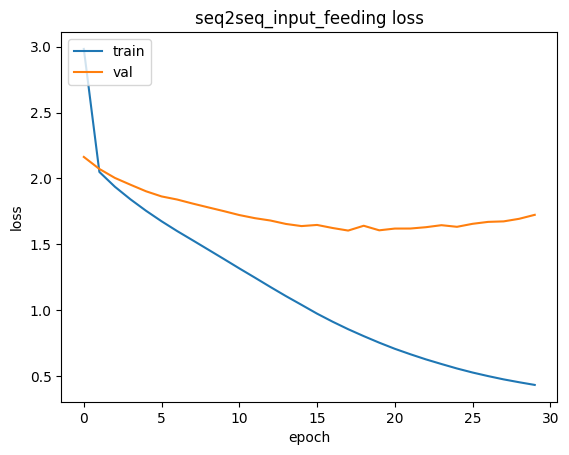

In [133]:
# Resume o histórico de acurácia: plota a acurácia para os conjuntos de treinamento e validação
plt.plot(history.history['accuracy'])       # Acurácia durante o treinamento
plt.plot(history.history['val_accuracy'])     # Acurácia durante a validação
plt.title(model.name + ' accuracy')           # Define o título do gráfico (nome do modelo + 'accuracy')
plt.ylabel('accuracy')                        # Rótulo do eixo y
plt.xlabel('epoch')                           # Rótulo do eixo x
plt.legend(['train', 'val'], loc='upper left')  # Adiciona a legenda indicando os conjuntos
plt.show()                                    # Exibe o gráfico de acurácia

# Resume o histórico de perda: plota a perda para os conjuntos de treinamento e validação
plt.plot(history.history['loss'])             # Perda durante o treinamento
plt.plot(history.history['val_loss'])           # Perda durante a validação
plt.title(model.name + ' loss')                # Define o título do gráfico (nome do modelo + 'loss')
plt.ylabel('loss')                            # Rótulo do eixo y
plt.xlabel('epoch')                           # Rótulo do eixo x
plt.legend(['train', 'val'], loc='upper left')  # Adiciona a legenda indicando os conjuntos
plt.show()                                    # Exibe o gráfico de perda
